# Event finder & raw data checker

This notebook will find competitive cellular "events" in the simplest definition (i.e. a loser cell apoptosis) and return information about the spatiotemporal distrubition of counterpart competitive events (i.e. winner cell mitosis)

Contents:

- Load modules
- Load cell finding functions
- Set experiment data path
- Load image data
- Load tracking data
- Apply necessary coordinate shift for viewer
- Isolate one track of interest (target track)
- Find corresponding tracks/events of interest within a given spatiotemporal range (E.g. if target track is Scr apoptosis, then find all nearby wild-type mitosis)
- Set points and regions of interest for highlighting in Napari viewer(now set as functions so this bit is automatic
- Launch Napari image viewer if desired

To-do:

- [x] Reorganise structure so that scan over all R then filter
- [x] Create radial bins and sort tracks into them
- [ ] Create temporal bins
- [ ] Figure out how to plot said bins into heat map image
- [ ] Check redesigned script against raw data 

In [1]:
import napari
import btrack
import numpy as np
from skimage.io import imread
import os
print("Napari version no.:", napari.__version__)
print("btrack version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON, tracks_to_napari
from tqdm.notebook import tnrange, tqdm
import matplotlib.pyplot as plt

Napari version no.: 0.4.0
btrack version no.: 0.4.0


### Functions to measure local neighbourhood for cells of interest

In [2]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(find_apoptosis_time(target_track, index = False)) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame)
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    dt = target_track.t[idx0] - other_track.t[idx1]
    
    return np.sqrt(dx**2 + dy**2) #, dt

def find_apoptosis_time(target_track, index): ### if index is set to True then the index of the apoptotic time (wrt target_track) is returned
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            break
    apop_time = target_track.t[apop_index]
    if index == True: 
        return apop_index
    else: 
        return apop_time

def find_nearby_wt_mitosis(target_track, delta_t, radius):
    frame = find_apoptosis_time(target_track, index = False) + delta_t 
    dividing_states = ('METAPHASE',) #('PROMETAPHASE', 'METAPHASE', 'DIVIDE')
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius]
    wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius if wt_track.label[wt_track.t.index(frame)] in dividing_states if wt_track.fate.name == "DIVIDE"] ###check this
  
    return wt_tracks_in_radius, wt_mitosis_in_radius


def maximum_xyt(i):
    #### BEWARE xy coord switch!     
    if i == 'x':
        max_x = int((max([max(i.y) for i in wt_tracks])))
        return max_x
    if i == 'y':
        max_y = int((max([max(i.x) for i in wt_tracks])))
        return max_y
    if i == 't':
        max_t = int((max([max(i.t) for i in wt_tracks])))
        return max_t
    
def plot_mitoses(): ## this function plots mitosis events into the napari viewer
    apop_event = target_track.t[apop_index], target_track.x[apop_index]+shift_y, target_track.y[apop_index]+shift_x ## with transposed shift
    t_m, x_m, y_m = np.zeros(len(wt_mitosis_in_radius)), np.zeros(len(wt_mitosis_in_radius)), np.zeros(len(wt_mitosis_in_radius))
    mito_events = np.zeros((len(wt_mitosis_in_radius), 3)) ## 3 because of the 3 cartesian coords 
    for i, wt_mitosis in enumerate(wt_mitosis_in_radius): ## this now assumes that the mitosis time point of relevance isnt the last frame of track but the time at delta_t, need to bolster definition of mitosis
        mito_index = [j for j, k in enumerate(wt_mitosis.t) if k == apop_event[0]+delta_t][0] ### [0] bc first item of list comprehension
        t_m[i], x_m[i], y_m[i] = wt_mitosis.t[mito_index], wt_mitosis.x[mito_index]+shift_y, wt_mitosis.y[mito_index]+shift_x ## plus transposed coordinate shift
        mito_events[i] = t_m[i], x_m[i], y_m[i]
    return viewer.add_points(mito_events, name = "Mitosis events", symbol = "cross", face_color = 'pink')

def plot_apoptosis(): ## this function plots apoptotic event and surrounding local environment scope (determined by radius)
    ### add_points needs to be txy
    apop_event = target_track.t[apop_index], target_track.x[apop_index]+shift_y, target_track.y[apop_index]+shift_x ## with transposed shift
    ## apop_circle is the bounding box of the ellipse highlighting radial extent around apoptosis, shown at the shifted time and apop time
    apop_circle = [((apop_event[0]+delta_t, apop_event[1]-radius, apop_event[2]-radius), 
                    (apop_event[0]+delta_t, apop_event[1]+radius, apop_event[2]-radius), 
                    (apop_event[0]+delta_t, apop_event[1]+radius, apop_event[2]+radius), 
                    (apop_event[0]+delta_t, apop_event[1]-radius, apop_event[2]+radius)), 
                    ((apop_event[0], apop_event[1]-radius, apop_event[2]-radius), 
                    (apop_event[0], apop_event[1]+radius, apop_event[2]-radius), 
                    (apop_event[0], apop_event[1]+radius, apop_event[2]+radius), 
                    (apop_event[0], apop_event[1]-radius, apop_event[2]+radius))]
    
    return viewer.add_points(apop_event, name = "Apoptosis event", symbol = 'x', face_color = "c"), viewer.add_shapes(apop_circle, opacity = 0.1, shape_type = 'ellipse', face_color = 'y', name = 'Radial environment')
    


### Set experiment data path 

In [3]:
# print("Input experiment number")
# experiment_no = input()
# root_path = os.path.join('/home/nathan/data/kraken/h2b/giulia/', experiment_no)
root_path = '/home/nathan/data/kraken/h2b/giulia/GV0807'  ## this overwrites input option for ease 
gfp_path = os.path.join(root_path, 'Pos3/stacks/gfp.tif')
rfp_path = os.path.join(root_path, 'Pos3/stacks/rfp.tif')
bf_path = os.path.join(root_path, 'Pos3/stacks/bf.tif')
tracks_path = os.path.join(root_path, 'Pos3/Pos3_aligned/HDF/segmented.hdf5')

### Load image data

In [4]:
gfp = imread(gfp_path)

In [ ]:
rfp = imread(rfp_path)

In [ ]:
#bf = imread(bf_path) #3 large 1000+ frame stacks is usually too much for memory to process on 16gb ram

### Load tracking data

In [5]:
with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_1") as hdf:
    wt_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_2") as hdf:
    scr_tracks = hdf.tracks
print("Tracks loaded")

### finding coord range of aligned images, coords switched already
align_x_range, align_y_range = gfp.shape[2], gfp.shape[1]
### finding maximum extent of tracking coords
tracks_x_range = round(max([max(track.x) for track in wt_tracks]))
tracks_y_range = round(max([max(track.y) for track in wt_tracks])) + 2 ## sort this lazy hack out later

### coord switch
tmp = tracks_y_range
tracks_y_range = tracks_x_range
tracks_x_range = tmp

print("tracks range:", (tracks_x_range), (tracks_y_range))
print("aligned image range:", (align_x_range), (align_y_range))

shift_x = int((align_x_range - tracks_x_range)/2)
shift_y = int((align_y_range - tracks_y_range)/2)

print("shift in x and y:", shift_x, shift_y)

wt_data, properties, graph = tracks_to_napari(wt_tracks, ndim = 2)
scr_data, properties, graph = tracks_to_napari(scr_tracks, ndim = 2)

tmp = wt_data[:,2].copy() ## copy the true_y coord
wt_data[:,2] = wt_data[:,3]  ##assign the old_y coord as the true_x
wt_data[:,3] = tmp ## assign the old_x as true_y

wt_data[:,2] += shift_y ## TRUE_Y (vertical axis)
wt_data[:,3] += shift_x ## TRUE_X (horizontal axis)

tmp = scr_data[:,2].copy()
scr_data[:,2] = scr_data[:,3]
scr_data[:,3] = tmp

scr_data[:,2] += shift_y ## TRUE_Y (vertical axis)
scr_data[:,3] += shift_x ## TRUE_X (horizontal axis)

print("coordinate shift applied")

[INFO][2020/12/18 05:17:36 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/12/18 05:17:36 PM] Loading tracks/obj_type_1
[INFO][2020/12/18 05:17:38 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2020/12/18 05:17:41 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2020/12/18 05:17:41 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/12/18 05:17:42 PM] Loading tracks/obj_type_2
[INFO][2020/12/18 05:17:42 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2020/12/18 05:17:42 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Tracks loaded
tracks range: 1600 1200
aligned image range: 1739 1377
shift in x and y: 69 88
coordinate shift applied


### Isolate one track of interest

In [6]:
## isolate one target scribble track of interest
print("input scribble track of interest ID")
cell_ID = int(input())
index = [i for i, scr_tracks in enumerate(scr_tracks) if scr_tracks.ID == cell_ID][0]
target_track = scr_tracks[index]##### Show the first classification of each track
apop_index, apop_time = find_apoptosis_time(target_track, index = True), find_apoptosis_time(target_track, index = False)  

input scribble track of interest ID
17


In [ ]:
### isolate other wt cell of interest
cell_ID = 591
index = [i for i, wt_tracks in enumerate(wt_tracks) if wt_tracks.ID == cell_ID][0]
other_target_track = wt_tracks[index]

In [ ]:
for i in range(len(other_target_track)):
    print(other_target_track.t[i], other_target_track.label[i])

# Find cells of interest

In [7]:
radius = 500
delta_t = 0
wt_tracks_in_radius, wt_mitosis_in_radius = find_nearby_wt_mitosis(target_track, delta_t, radius)
## display ID for all tracks found in radius 
print("ID for all tracks in radius:", [j.ID for i, j in enumerate(wt_tracks_in_radius)])
print("ID for all mitoses in radius:", [j.ID for i, j in enumerate(wt_mitosis_in_radius)])

ID for all tracks in radius: [42, 4, 94, 109, 143, 169, 189, 218, 311, 330, 340, 346, 344, 380, 381, 405, 420, 421, 437, 436, 445, 446, 455, 456, 462, 490, 493, 508, 507, 526, 527, 533, 535, 561, 560, 585, 587, 588, 589, 591, 601, 603, 604, 618, 621, 622, 631, 632, 648, 649, 650, 657, 658, 664, 666, 673, 674, 690, 691, 704, 705, 719, 717, 720, 721, 732, 734, 736, 737, 745, 748, 751, 752, 753, 757, 763, 762, 760, 761, 768, 769, 770, 771, 776, 781, 785, 787, 788, 795, 797, 798, 799, 800, 803, 810, 811, 818, 836, 837, 844, 845, 848, 849, 850, 851, 854, 853, 858, 859, 863, 865, 867, 874, 896, 897, 900, 906, 905, 901, 913, 914, 924, 920, 927, 932, 933, 938, 937, 939, 947, 948, 949, 950, 959, 960, 972, 974, 978, 979, 980, 987, 992, 993, 994, 997, 998, 1020, 1019, 1015, 1014, 1013]
ID for all mitoses in radius: [445]


to-do: 
- [x] take output of wt_tracks_in_radius and bin into discrete distance cats
- [ ] bin time periods and figure way to iterate over discrete time cats
- [ ] try new architecture based on filtering over R and T
- [ ] plot bins into heatmap

alternative idea for structure: iterate over cells calculating dt and dxy and then plot 

# sandbox

In [8]:
radius = 200
#frame = 730
delta_t = 100

In [9]:
num_radial_bins = 5
radial_bin = radius / num_radial_bins
num_temporal_bins = 5
temporal_bin = delta_t / num_temporal_bins
print(temporal_bin, radial_bin)

20.0 40.0


In [ ]:
## load one wt_track
for j, wt_track in enumerate(wt_tracks):  
    ## load first timepoint of wt_track
    for i in range(len(wt_track)): 
        ## load first distance/radial bin
        for n in range(num_radial_bins):
            ## calculate if within euclidean distance: if min of radial distance bin < (wt_track.x (at first time point) - target_track.x (at apop_time)) both squared + corresponding for yboth squared < max_dist squared
            if ((radial_bin * n)**2) < (wt_track.x[i] - target_track.x[apop_index])**2 + (wt_track.y[i] - target_track.y[apop_index])**2 < (radial_bin * (n+1))**2:
            ### if distance in the first time point! do I need over any i that wt_track.x/y exists in?
                ## load first temporal bin
                for m in range(num_temporal_bins):
                    ## if FIRST time point is in temporal bin (centered around apop_time)
                    if wt_track.t[i] in (range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1)))):
                        #print("WT ID:", wt_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                        if wt_track.fate.name == "DIVIDE" and "'METAPHASE', 'METAPHASE'," in str(wt_track.label[int(apop_time+(temporal_bin*m))-wt_track.t[0]:int(apop_time+(temporal_bin*(m+1)))-wt_track.t[0]]): ##explainer: this double condition states that if wt_track ends in mitosis but also has THREE (?) sequential metaphase classifications within the time window of that temporal bin then the condition is met
                            #print("MITO ID:", wt_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)

this block is wrong as it breaks out of loops too much ie only finding one cell per bin

expanded wrong block

In [ ]:
## load one wt_track
for j, wt_track in enumerate(wt_tracks):  
    ## load first timepoint of wt_track
    track_length = range(len(wt_track))
    for i in track_length: 
        ## load first distance/radial bin
        for n in range(num_radial_bins):
            min_distance = radial_bin * n
            max_distance = radial_bin * (n+1)
            delta_x = wt_track.x[i] - target_track.x[apop_index] ### if distance in the first time point! do I need over any i that wt_track.x/y exists in?
            delta_y = wt_track.y[i] - target_track.y[apop_index]
            ## calculate if within euclidean distance: if min of radial distance bin < (wt_track.x (at first time point) - target_track.x (at apop_time)) both squared + corresponding for yboth squared < max_dist squared
            if (min_distance**2) < (delta_x**2 + delta_y**2) < (max_distance**2):
                ## load first temporal bin
                for m in range(num_temporal_bins):
                    ## if FIRST time point is in temporal bin (centered around apop_time)
                    wt_track_timepoint = wt_track.t[i]
                    min_time = int(apop_time+temporal_bin*m)
                    max_time = int(apop_time+temporal_bin*(m+1))
                    aligned_temporal_bin = range(min_time,max_time) ## aligned around apop_time
                    if wt_track_timepoint in aligned_temporal_bin:
                        ## print all wt_tracks satisfying conditions
                        print("WT ID:", wt_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                        wt_track_labels = str(wt_track.label[min_time-wt_track.t[0]:max_time-wt_track.t[0]]) ## state labels within the time window of that temporal bin
                        if wt_track.fate.name == "DIVIDE" and "'METAPHASE', 'METAPHASE'," in wt_track_labels: 
                            print("MITO ID:", wt_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                        break
                break
        break ## this loop breaks when the first instance has been found, could reverse order of iteration to get the last instance?

exploring order and speed of above bloc

In [33]:
from tqdm import tqdm
import numpy as np

In [69]:
radius = 300
delta_t = 200

In [70]:
num_radial_bins = 20
radial_bin = radius / num_radial_bins
num_temporal_bins = 20
temporal_bin = delta_t / num_temporal_bins
print(temporal_bin, radial_bin)

10.0 15.0


In [71]:
num_wt = np.zeros((num_radial_bins, num_temporal_bins))
num_wt_mito = np.zeros((num_radial_bins, num_temporal_bins))


In [ ]:
## instead of going over all tracks, could go over all tracks that are definitely in_frame (using func) or in zone 

## load one wt_track
for j, wt_track in enumerate(tqdm(wt_tracks)):
    ## load first distance/radial bin
    print("ID:", wt_track.ID)
    for n in range(num_radial_bins):
        ## load first temporal bin
        print("radial", range(int(radial_bin * n), int(radial_bin * (n+1))))
        for m in range(num_temporal_bins):
            ## load first timepoint of wt_track
            print("time",range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1))))
            for i in range(len(wt_track)): 
                ## calculate if within euclidean distance: if min of radial distance bin sqrd < (wt_track.x (at first time point) - target_track.x (at apop_time)) both squared + corresponding for yboth squared < max_dist squared
                if ((radial_bin * n)**2) < (wt_track.x[i] - target_track.x[apop_index])**2 + (wt_track.y[i] - target_track.y[apop_index])**2 < ((radial_bin * (n+1))**2):
                    ## if FIRST time point is in temporal bin (centered around apop_time)
                    if wt_track.t[i] in (range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1)))):
                        num_wt[n,m] += 1 #str(wt_track.ID)
                        print("wt_track", wt_track.ID)
                        #print("WT ID:", wt_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                        if wt_track.fate.name == "DIVIDE" and "'METAPHASE', 'METAPHASE'," in str(wt_track.label[int(apop_time+(temporal_bin*m))-wt_track.t[0]:int(apop_time+(temporal_bin*(m+1)))-wt_track.t[0]]): ##explainer: this double condition states that if wt_track ends in mitosis but also has THREE (?) sequential metaphase classifications within the time window of that temporal bin then the condition is met
                            num_wt_mito[n,m] += 1 #str(wt_track.ID)
                            print("wt_track mitosis", wt_track.ID)
                            #print("MITO ID:", wt_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)




  0%|          | 0/3887 [00:00<?, ?it/s]

ID: 36
radial range(0, 15)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(15, 30)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(30, 45)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time ra

time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(285, 300)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)





  0%|          | 1/3887 [00:06<6:36:49,  6.13s/it]

time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
ID: 25
radial range(0, 15)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(15, 30)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time ra

time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(285, 300)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)





  0%|          | 2/3887 [00:16<8:06:11,  7.51s/it]

time range(900, 910)
time range(910, 920)
time range(920, 930)
ID: 26
radial range(0, 15)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(15, 30)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(30, 45)
time range(730, 740)
time ra




  0%|          | 3/3887 [00:17<5:52:04,  5.44s/it]

 range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(75, 90)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(90, 105)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 




  0%|          | 4/3887 [00:17<4:09:29,  3.86s/it]

 range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(30, 45)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(45, 60)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 8

time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(15, 30)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(30, 45)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(81

time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(285, 300)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)





  0%|          | 5/3887 [00:27<6:01:17,  5.58s/it]

time range(900, 910)
time range(910, 920)
time range(920, 930)
ID: 29
radial range(0, 15)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(15, 30)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(30, 45)
time range(730, 740)
time ra

time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(285, 300)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)





  0%|          | 6/3887 [00:59<14:31:01, 13.47s/it]

ID: 30
radial range(0, 15)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(15, 30)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(30, 45)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time ra

time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(285, 300)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)





  0%|          | 7/3887 [01:02<11:15:55, 10.45s/it]

ID: 31
radial range(0, 15)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(15, 30)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(30, 45)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time ra

time range(910, 920)
time range(920, 930)
radial range(285, 300)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)





  0%|          | 8/3887 [01:10<10:23:42,  9.65s/it]

time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
ID: 32
radial range(0, 15)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(15, 30)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time ra




  0%|          | 9/3887 [01:11<7:46:27,  7.22s/it] 

range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(255, 270)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(270, 285)
time range(730, 740)
time range(740, 750)
time range(750, 760)
time range(760, 770)
time range(770, 780)
time range(780, 790)
time range(790, 800)
time range(800, 810)
time range(810, 820)
time range(820, 830)
time range(830, 840)
time range(840, 850)
time range(850, 860)
time range(860, 870)
time range(870, 880)
time range(880, 890)
time range(890, 900)
time range(900, 910)
time range(910, 920)
time range(920, 930)
radial range(285, 300)
time range(7

In [66]:
print(num_wt, num_wt_mito)

[[  3.  20.  20.   0.   0.  10.  20.  20.  30.  28.]
 [ 66.  16.  57.  87.  80.  72.  60.  60.  50.  46.]
 [ 72.  90.  52.  41.  39.  43.  91. 106. 110. 136.]
 [ 80.  75.  82. 106. 122. 106. 111.  99.  77.  70.]
 [139. 149. 129.  91. 109. 143. 173. 192. 207. 196.]
 [195. 207. 171. 175. 141. 126. 186. 181. 216. 198.]
 [201. 195. 207. 210. 212. 211. 186. 181. 218. 281.]
 [229. 260. 278. 272. 262. 295. 306. 324. 282. 260.]
 [193. 284. 259. 241. 282. 261. 275. 331. 340. 369.]
 [283. 257. 306. 287. 230. 263. 294. 348. 414. 445.]] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 17.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 23. 15.  0.  0.  0.]
 [ 0. 20.  0.  4.  0. 26.  0.  0.  4.  0.]
 [ 0. 10.  0.  5.  0.  0.  3.  0.  3.  8.]
 [ 0. 16.  0.  0. 20.  0.  1.  0.  3.  0.]
 [ 0.  4. 15. 14.  0.  0.  0.  0. 13.  0.]
 [ 0.  0.  9.  0.  0.  0. 20. 12.  0.  0.]
 [12.  0.  0.  0.  0.  1. 18.  0.  0.  6.]]


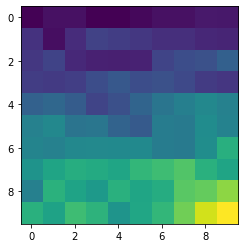

In [67]:
plt.imshow(num_wt)

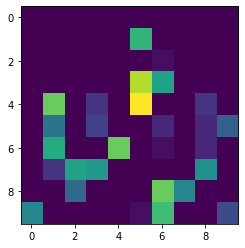

In [68]:
plt.imshow(num_wt_mito)

In [ ]:
### checking how the tracker classifies state labels leading up to mitosis, seems the best classification is just a single metaphase but also double metaphase maybe more rigorous
count1 = 0
count2 = 0
for i, wt_track in enumerate(wt_tracks):
    if wt_track.fate.name == "DIVIDE":
        count1 += 1
        print(i,wt_track.ID, wt_track.label[-5:])
        if str(wt_track.label[-1:]) == "['METAPHASE']": #"['METAPHASE', 'METAPHASE']"
            count2 += 1
print("accuracy of classification above is", (count2/count1 *100))

distance binned but time not 

In [ ]:
t_range = range(-200,200)
wt_mito_ID_temporal_bins = {}

## create bins automatically
num_bins = 10
bin_size = radius / num_bins
## create dict for wt data storage
wt_track_bins = {}
wt_ID_bins = {} ## temp measure to create parallel dict just listing the IDs so that i can check algorithm works against raw data
wt_mitosis_bins = {}
wt_mito_ID_bins = {} ## temp measure to create parallel dict just listing the IDs so that i can check algorithm works against raw data

wt_tracks_in_radius = []
wt_mitosis_in_radius = []

for delta_t in t_range:
    ## creating temporal bin label
    temporal_bin_label = "frame" + str(find_apoptosis_time(target_track, index = False) + delta_t)
    wt_mito_ID_temporal_bins[temporal_bin_label] = {}
    radius = 500 ## maximum radius
    ## count all cells and mitoses within radius at delta_t
   
    wt_tracks_in_radius, wt_mitosis_in_radius = find_nearby_wt_mitosis(target_track, delta_t, radius)
    print("time", delta_t, "wt", len(wt_tracks_in_radius), "mito", len(wt_mitosis_in_radius))## currently returning zero hmmm
    ## iterate over all bins
    for i in range(num_bins):
        ## create bin label for dict entry 
        bin_label = str((bin_size * i)) + "< radial distance <" + str((bin_size * (i+1))) 
        ## create empty list to store each bins data in before storing
        wt_trackz = []
        wt_IDs = [] ## temp measure
        for wt_track in wt_tracks_in_radius:
            if (bin_size * i) <= euclidean_distance(target_track, wt_track, (find_apoptosis_time(target_track, index = False) + delta_t)) <= (bin_size*(i+1)):
                ## add track info to list for saving in dict bin entry
                wt_trackz.append(wt_track) 
                wt_IDs.append(wt_track.ID) ## temp measure
        ## add list of cells to dict entry
        wt_track_bins[bin_label] = wt_tracks
        wt_ID_bins[bin_label] = wt_IDs

        wt_mito_IDs = [] ## temp measure
        wt_mitos = []
        for wt_mito in wt_mitosis_in_radius:
            if (bin_size * i) <= euclidean_distance(target_track, wt_mito, (find_apoptosis_time(target_track, index = False) + delta_t)) <= (bin_size*(i+1)):
                ## add track info to list for saving in dict bin entry
                wt_mitos.append(wt_mito) 
                wt_mito_IDs.append(wt_mito.ID) ## temp measure
        ## add list of cells to dict entry
        wt_mitosis_bins[bin_label] = wt_mitos
        wt_mito_ID_bins[bin_label] = wt_mito_IDs
        #print(wt_mito_IDs, delta_t)
        
        #wt_mito_ID_temporal_bins[temporal_bin_label][bin_label] = wt_mito_IDs

In [ ]:
wt_mito_ID_temporal_bins

plotting wt_mito_ID_temporal_bins

In [ ]:
wt_mito_ID_temporal_bins['frame685']

In [ ]:
heatmap = np.zeros((10,400))

for i, key1 in enumerate(wt_mito_ID_temporal_bins.keys()):
    #print(i, key1)
    for j, key2 in enumerate(wt_mito_ID_temporal_bins['frame685'].keys()):
        #print(j,key2)
        if len(wt_mito_ID_temporal_bins[key1][key2]) > 4:
            print(key1, key2)
            print(len(wt_mito_ID_temporal_bins[key1][key2]))
        heatmap[j,i] = len(wt_mito_ID_temporal_bins[key1][key2])
#heatmap[:,0] = wt_mito_ID_temporal_bins[i][j]

In [ ]:
plt.imshow(heatmap, cmap= 'viridis', aspect = 'auto')#, #interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,9)
#plt.xlim(0,10)
#plt.clim(0,3)
plt.title("Number of wild-type mitosis")
plt.text(195,-4.5, "Scr apoptosis -", rotation=90)
plt.xlabel("frame (unaligned)")
plt.ylabel("distance (50pixel bins)")
plt.savefig("/home/nathan/data/number_heatmap_Scr17.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()

### Launch napari to check against raw data 

In [ ]:
with napari.gui_qt():
    viewer = napari.Viewer()
    
    #viewer.add_image(bf)
    viewer.add_image(gfp, name="gfp", blending = "additive", colormap = "green")
    viewer.add_image(rfp, name="rfp", contrast_limits = (0, 50), blending = "additive", colormap = "red")
    
    viewer.add_tracks(wt_data)
    viewer.add_tracks(scr_data)
    
    plot_mitoses() ## utilises two functions above to plot apop and mito 
    plot_apoptosis()
    viewer.dims.set_point(0, (apop_time + delta_t)) ## open viewer at the timepoint of interest